In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from linearmodels import PanelOLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
import plotly.express as px

sns.set_theme()

# Functions

In [2]:
# Definisci una funzione per mappare i paesi alle regioni
def assign_region(country):
    country = HDR_ISO_country[country]
    if country in Asia:
        return 'EAP'
    elif country in Europe_Central_Asia:
        return 'ECA'
    elif country in Weastern_Europe:
        return 'WE'
    elif country in North_America:
        return 'NA'
    elif country in Arab_states:
        return 'AS'
    elif country in Oceania:
        return 'OC'
    elif country in Areas:
        return 'AREA'

In [3]:
def Pivoting(df): # Function to pivot the dataframe
    df_r = df.pivot(index=['iso3','hdicode','region','year'], columns='indicator_name', values='value').reset_index()
    df_r.reset_index(inplace=True)
    df_r.columns.name = None
    df_r.drop(columns=['index'], inplace=True)
    df_r['year'] = pd.to_datetime(df_r['year'], format='%Y',errors='coerce').dt.year
    return df_r

In [4]:
def PrepareData(df,ind): # Function to prepare the data for analysis
    Panel = df.copy()
    shift = ind.replace('_value', '') + '_shifted'
    Panel[shift] = Panel.groupby('iso3')[ind].shift(1)
    Panel[shift].dropna(inplace=True) # Drop rows with NaN values
    return Panel

In [5]:
def Regression(Panel,independent_vars,dependent_var): # Function to run the regression
    L = ['iso3','year']
    L.extend(independent_vars)
    L.append(dependent_var)
    model_df = Panel[L].copy()
    model_df = model_df.set_index(['iso3', 'year'])
    model_df = model_df.dropna() # Drop rows with NaN values
    model_df[independent_vars] = model_df[independent_vars].apply(pd.to_numeric, errors='coerce')
    model_df[dependent_var] = model_df[dependent_var].apply(pd.to_numeric, errors='coerce')

    Y = model_df[dependent_var]
    X = model_df[independent_vars]
    X = sm.add_constant(X)

    mod_fe = PanelOLS(Y,X, entity_effects=True, time_effects=True)
    results = mod_fe.fit(cov_type='clustered',cluster_entity=True)

    return results.summary

# Data loading and preparation

## Data Loading

In [6]:
path = 'Datasets/'

gdp_pc_ppp = pd.read_csv(path + 'GDP per capita, PPP (current international)/WB_WDI_NY_GDP_PCAP_PP_CD.csv') # GDP per capita, PPP (current international $)
hdr = pd.read_csv(path + 'HDR/HDR25_Composite_indices_complete_time_series.csv',encoding='latin1') # Human Development Index
hdr_labels = pd.read_excel(path + 'HDR/HDR25_Composite_indices_metadata.xlsx', sheet_name = 'codebook') # Human Development
schooling = pd.read_csv(path+'UNESCO/OPRI_DATA_NATIONAL.zip', dtype={'INDICATOR_ID': 'object'}, compression='zip')  # Schooling data
schooling_labels = pd.read_csv(path+'UNESCO/OPRI_LABEL.csv') # Schooling labels
gs = pd.read_csv(path + 'GenderStatistics/GS.csv') # Globalization data

/var/folders/pl/qxmk8x1d1m586z4_j013bvqw0000gn/T/ipykernel_23917/247098959.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  schooling = pd.read_csv(path+'UNESCO/OPRI_DATA_NATIONAL.zip', dtype={'INDICATOR_ID': 'object'}, compression='zip')  # Schooling data


## Data preparation

In [7]:
GS = gs.copy()
GS = GS.drop(columns=['Unnamed: 0'])
GS = GS.rename(columns={'REF_AREA': 'iso3', 'YEAR': 'year'})

### HDR

In [8]:
HDR_ISO_country = {hdr['iso3'][i]:hdr['country'][i] for i in range(len(hdr))}

In [9]:
hdr_labels.drop(columns=['Time series'], inplace=True)
hdr_labels.dropna(subset=['Short name'], inplace=True)
hdr_labels.rename(columns={'Full name': 'indicator_name', 'Short name': 'indicator'}, inplace=True)

In [10]:
HDR = hdr.copy()
df_melted = HDR.melt(id_vars=['iso3', 'country', 'hdicode', 'region', 'hdi_rank_2023'], var_name='indicator_year', value_name='value') # Melt the dataframe to long format
df_melted[['indicator', 'year']] = df_melted['indicator_year'].str.extract(r'([a-z0-9_]+)_(\d{4})')
df_final = df_melted[['iso3','hdicode','region','year', 'indicator', 'value']] # Reorder and select final columns
HDR = pd.merge(hdr_labels, df_final, on=['indicator'], how='right') # Merge with labels

In [11]:
North_America = ['Canada','United States'] 
Oceania = ['Australia','New Zealand'] 
Asia = ['Hong Kong, China (SAR)','Korea (Republic of)','Japan'] 
Europe_Central_Asia = ['Cyprus','Russian Federation','Israel'] 
Weastern_Europe = ['Andorra', 'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Czechia', 'Denmark', 
                   'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 
                   'Italy', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Monaco', 
                   'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'San Marino', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland','United Kingdom']
Arab_states = ['Algeria', 'Bahrain', 'Djibouti', 'Egypt', 'Iraq', 'Jordan']
Areas = ['Very high human development', 'High human development',
       'Medium human development', 'Low human development', 'Arab States',
       'East Asia and the Pacific', 'Europe and Central Asia',
       'Latin America and the Caribbean', 'South Asia',
       'Sub-Saharan Africa', 'World']

In [12]:
h = HDR[HDR['region'].isna()].copy()
h.loc[:,'region'] = h.loc[:,'iso3'].apply(assign_region)
HDR = pd.concat([HDR[~HDR['region'].isna()], h], ignore_index=True) # Concatenate the two dataframes


In [13]:
region_labels = {
    'ECA': 'Europe & Central Asia',
    'AS':  'Arab States',
    'SSA': 'Sub-Saharan Africa', 
    'LAC': 'Latin America & Caribbean',
    'SA':  'South Asia',
    'EAP': 'East Asia & Pacific',
    'AS':  'Arab States',
    'NA': 'North America',
    'WE': 'Western Europe',
    'OC': 'Oceania'
}

In [14]:
HDI_indicators = ['hdi', 'le', 'eys', 'mys', 'gnipc']
GDI_indicators = ['gdi_group', 'gdi', 'hdi_f', 'le_f', 'eys_f', 'mys_f', 'gni_pc_f', 'hdi_m', 'le_m', 'eys_m', 'mys_m', 'gni_pc_m']
IHDI_indicators = ['ihdi', 'coef_ineq', 'loss', 'ineq_le', 'ineq_edu', 'ineq_inc']
GII_indicators = ['gii_rank', 'gii', 'mmr', 'abr', 'se_f', 'se_m', 'pr_f', 'pr_m', 'lfpr_f', 'lfpr_m']
PHDI_indicators = ['rankdiff_hdi_phdi', 'phdi', 'diff_hdi_phdi', 'co2_prod', 'mf']
Population_indicator = ['pop_total']

In [15]:
hdi = HDR[HDR['indicator'].isin(HDI_indicators+Population_indicator)]
gdi = HDR[HDR['indicator'].isin(GDI_indicators+Population_indicator)]
ihdi = HDR[HDR['indicator'].isin(IHDI_indicators+Population_indicator)]
gii = HDR[HDR['indicator'].isin(GII_indicators+Population_indicator)]
phdi = HDR[HDR['indicator'].isin(PHDI_indicators+Population_indicator)]

In [16]:
HDI = Pivoting(hdi)
GDI = Pivoting(gdi)
IHDI = Pivoting(ihdi)
GII = Pivoting(gii)

In [17]:
HDR_idx = {'hdi': 'Human Development Index (value)', 'gii': 'Gender Inequality Index (value)', 'gdi': 'Gender Development Index (value)', 'ihdi': 'Inequality-adjusted Human Development Index (value)'}

#### GDP per Capita PPP

In [18]:
WB_ISO_country = {gdp_pc_ppp['REF_AREA_ID'][i]:gdp_pc_ppp['REF_AREA_NAME'][i] for i in range(len(gdp_pc_ppp))}

In [19]:
GDP = gdp_pc_ppp.copy()
GDP = GDP[['REF_AREA_ID','TIME_PERIOD','OBS_VALUE']]
GDP.rename(columns={'REF_AREA_ID':'iso3','TIME_PERIOD':'year','OBS_VALUE':'GDP'},inplace=True)
GDP['year'] = pd.to_datetime(GDP['year'], format='%Y',errors='coerce').dt.year
GDP['logGDP'] = np.log(GDP['GDP'])

#### Schooling

In [20]:
SCH = schooling.copy()
SCH['INDICATOR_ID'] = SCH['INDICATOR_ID'].astype(str)
SCH = SCH[SCH['INDICATOR_ID'].str.contains('NART', na=False)] 
SCH = SCH.drop(columns=['MAGNITUDE','QUALIFIER'])
SCH = pd.merge(schooling_labels,SCH,how='left',on='INDICATOR_ID') # Merge the labels with the schooling data
SCH['YEAR'] = pd.to_datetime(SCH['YEAR'], format='%Y',errors='coerce').dt.year 

In [21]:
Primary = SCH[SCH['INDICATOR_ID'].str.contains('NART.1', na=False)] # Filter for primary education
Secondary = SCH[SCH['INDICATOR_ID'].str.contains('NART.2', na=False)] # Filter for secondary education
Tertiary = SCH[SCH['INDICATOR_ID'].str.contains('NART.3', na=False)] # Filter for tertiary education

In [22]:
P = Primary.pivot(index=['COUNTRY_ID','YEAR'], columns='INDICATOR_LABEL_EN', values='VALUE').reset_index()
S = Secondary.pivot(index=['COUNTRY_ID','YEAR'], columns='INDICATOR_LABEL_EN', values='VALUE').reset_index()
T = Tertiary.pivot(index=['COUNTRY_ID','YEAR'], columns='INDICATOR_LABEL_EN', values='VALUE').reset_index()

In [23]:
P.rename(columns={'COUNTRY_ID':'iso3','YEAR':'year'}, inplace=True)
S.rename(columns={'COUNTRY_ID':'iso3','YEAR':'year'}, inplace=True)
T.rename(columns={'COUNTRY_ID':'iso3','YEAR':'year'}, inplace=True)

# Simple regressions

In [26]:
# GDP and GII
GDP_GII = pd.merge(GDP, GII, on=["iso3", "year"],how="inner")
GDP_GII.columns.name = None

Panel_GII = PrepareData(GDP_GII,HDR_idx['gii']) # Prepare the GII data
Regression(Panel_GII, independent_vars = [HDR_idx['gii']], dependent_var = 'logGDP') # Run the regression for GII

Dep. Variable:,logGDP,R-squared:,0.0023
Estimator:,PanelOLS,R-squared (Between):,-0.0582
No. Observations:,4527,R-squared (Within):,-0.0425
Date:,"Sat, May 10 2025",R-squared (Overall):,-0.0490
Time:,18:32:41,Log-likelihood,1525.8
Cov. Estimator:,Clustered,,
,,F-statistic:,9.9022
Entities:,170,P-value,0.0017
Avg Obs:,26.629,Distribution:,"F(1,4323)"
Min Obs:,2.0000,,
Max Obs:,34.000,F-statistic (robust):,0.2132


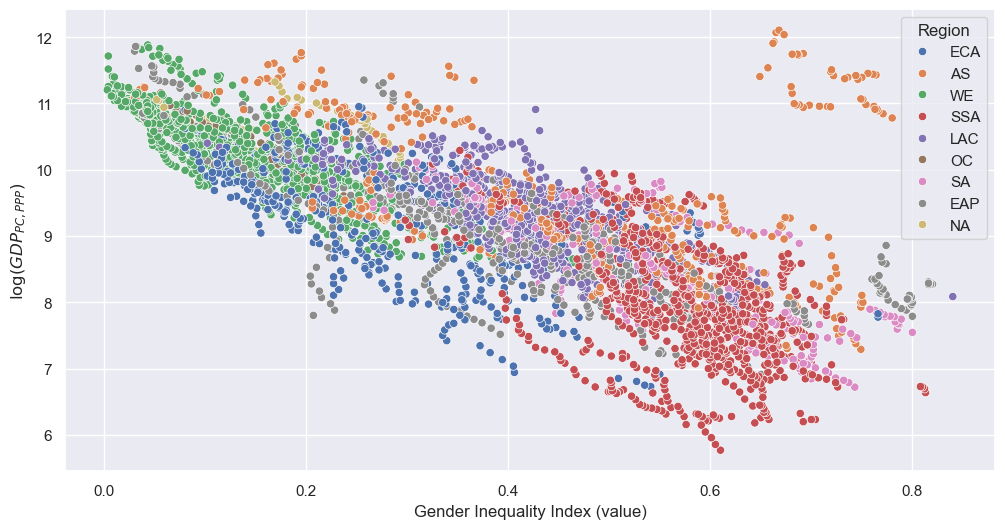

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=Panel_GII, x=HDR_idx['gii'], y='logGDP', hue='region')

plt.legend(title='Region')
plt.ylabel(r'$\log (GDP_{PC,PPP})$')
plt.show()

In [28]:
# GDP and GII+schooling
GDP_GII_Schooling = pd.merge(GDP_GII, T, on=["iso3", "year"],how="inner")
GDP_GII_Schooling.columns.name = None


Panel_GII_Schooling = PrepareData(GDP_GII_Schooling,HDR_idx['gii']) # Prepare the GII data
Panel_GII_Schooling['Total net attendance rate, upper secondary, female (%)'] = Panel_GII_Schooling['Total net attendance rate, upper secondary, female (%)']/100
Regression(Panel_GII_Schooling, independent_vars = [HDR_idx['gii'],'Total net attendance rate, upper secondary, female (%)'], dependent_var = 'logGDP') # Run the regression for GII

Dep. Variable:,logGDP,R-squared:,0.0228
Estimator:,PanelOLS,R-squared (Between):,0.0906
No. Observations:,564,R-squared (Within):,0.1407
Date:,"Sat, May 10 2025",R-squared (Overall):,0.1292
Time:,18:32:42,Log-likelihood,536.21
Cov. Estimator:,Clustered,,
,,F-statistic:,4.9917
Entities:,111,P-value,0.0072
Avg Obs:,5.0811,Distribution:,"F(2,428)"
Min Obs:,1.0000,,
Max Obs:,24.000,F-statistic (robust):,1.6246


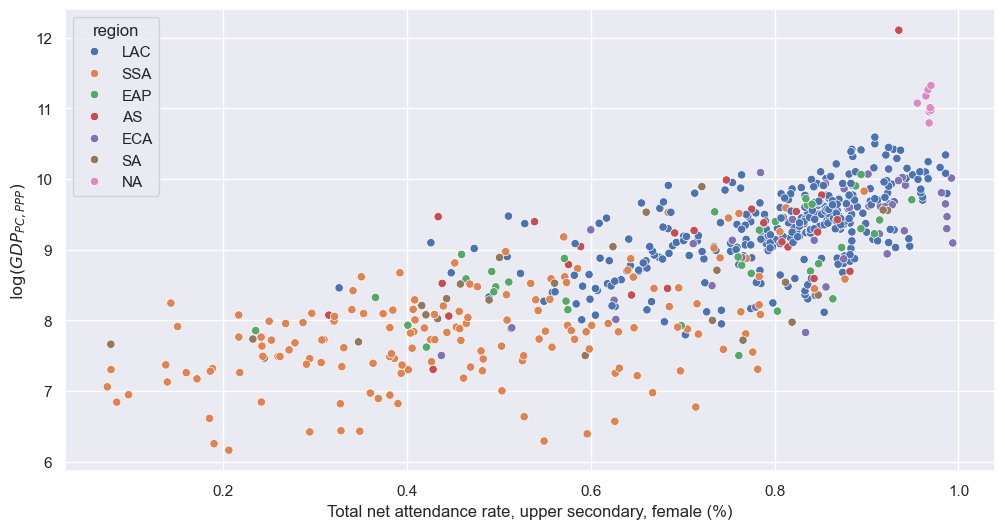

In [29]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=Panel_GII_Schooling, x='Total net attendance rate, upper secondary, female (%)', y='logGDP', hue='region')
plt.ylabel(r'$\log (GDP_{PC,PPP})$')
plt.show()

In [30]:
# GDP and GII - It can't be used with PanelOLS
GDP_GII_Schooling_GS = pd.merge(GDP_GII_Schooling, GS, on=["iso3", "year"],how="inner")
GDP_GII_Schooling_GS.columns.name = None

Panel_GII_Schooling_GS = PrepareData(GDP_GII_Schooling_GS,HDR_idx['gii']) # Prepare the GII data
vars = [HDR_idx['gii'],'Total net attendance rate, upper secondary, female (%)'] + GS.columns.to_list()[2:]
# Regression(Panel_GII_Schooling_GS, independent_vars = vars, dependent_var = 'logGDP') They do not change

In [31]:
# GDP and GII + Schooling + HDI_female
GDP_GII_Schooling_GDI = pd.merge(GDP_GII_Schooling, GDI, on=["iso3", "year"],how="inner")
GDP_GII_Schooling_GDI.columns.name = None


Panel_GII_Schooling_GDI = PrepareData(GDP_GII_Schooling_GDI,HDR_idx['gii']) # Prepare the GII data
Panel_GII_Schooling_GDI = PrepareData(Panel_GII_Schooling_GDI,'HDI female (value)') # Prepare the GII data
Regression(Panel_GII_Schooling_GDI, independent_vars = [HDR_idx['gii'],'Total net attendance rate, upper secondary, female (%)','HDI female (value)'], dependent_var = 'logGDP') # Run the regression for GII

Dep. Variable:,logGDP,R-squared:,0.1443
Estimator:,PanelOLS,R-squared (Between):,0.5969
No. Observations:,555,R-squared (Within):,0.5429
Date:,"Sat, May 10 2025",R-squared (Overall):,0.6408
Time:,18:32:43,Log-likelihood,563.23
Cov. Estimator:,Clustered,,
,,F-statistic:,23.504
Entities:,111,P-value,0.0000
Avg Obs:,5.0000,Distribution:,"F(3,418)"
Min Obs:,1.0000,,
Max Obs:,24.000,F-statistic (robust):,5.5254


In [32]:
# GDP and GII + HDI_female
GDP_GII_GDI = pd.merge(GDP_GII, GDI, on=["iso3", "year"],how="inner")
GDP_GII_GDI.columns.name = None

Panel_GII_GDI = PrepareData(GDP_GII_GDI,HDR_idx['gii']) # Prepare the GII data
Panel_GII_GDI = PrepareData(Panel_GII_GDI,'HDI female (value)') # Prepare the GII data
Regression(Panel_GII_GDI, independent_vars = [HDR_idx['gii'],'HDI female (value)'], dependent_var = 'logGDP') # Run the regression for GII

Dep. Variable:,logGDP,R-squared:,0.2047
Estimator:,PanelOLS,R-squared (Between):,0.6669
No. Observations:,4320,R-squared (Within):,0.5629
Date:,"Sat, May 10 2025",R-squared (Overall):,0.6588
Time:,18:32:44,Log-likelihood,2004.4
Cov. Estimator:,Clustered,,
,,F-statistic:,529.51
Entities:,170,P-value,0.0000
Avg Obs:,25.412,Distribution:,"F(2,4115)"
Min Obs:,2.0000,,
Max Obs:,34.000,F-statistic (robust):,41.612


In [33]:
# GDP and HDI_female
GDP_GDI = pd.merge(GDP, GDI, on=["iso3", "year"],how="inner")
GDP_GDI.columns.name = None

Panel_GDI = PrepareData(GDP_GDI,'HDI female (value)') # Prepare the GII data
Regression(Panel_GDI, independent_vars = ['HDI female (value)'], dependent_var = 'logGDP') # Run the regression for GII

Dep. Variable:,logGDP,R-squared:,0.1797
Estimator:,PanelOLS,R-squared (Between):,0.7097
No. Observations:,4824,R-squared (Within):,0.6265
Date:,"Sat, May 10 2025",R-squared (Overall):,0.6961
Time:,18:32:44,Log-likelihood,1829.0
Cov. Estimator:,Clustered,,
,,F-statistic:,1009.8
Entities:,182,P-value,0.0000
Avg Obs:,26.505,Distribution:,"F(1,4608)"
Min Obs:,2.0000,,
Max Obs:,34.000,F-statistic (robust):,42.987


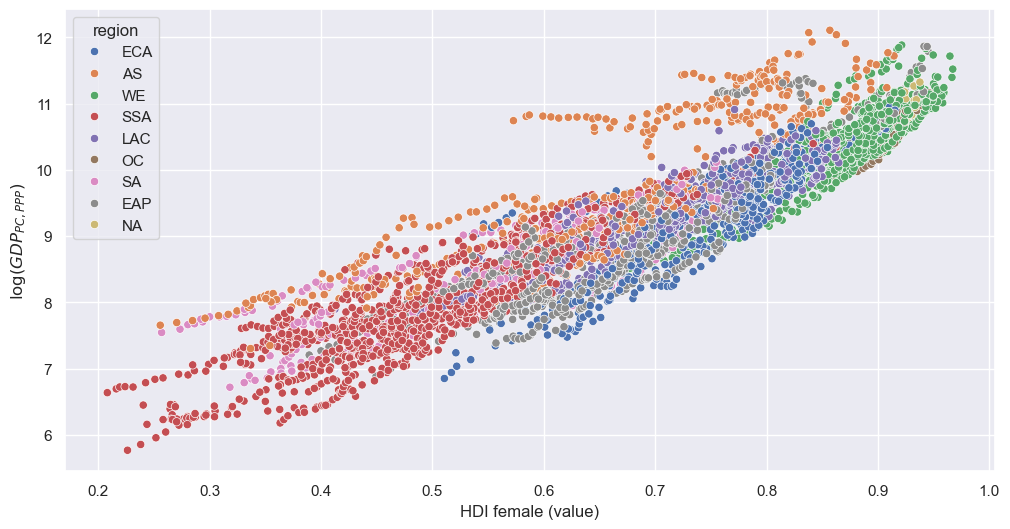

In [34]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=Panel_GDI, x='HDI female (value)', y='logGDP', hue='region')
plt.ylabel(r'$\log (GDP_{PC,PPP})$')
plt.show()

In [35]:
# GDP and GII
GDP_HDI = pd.merge(GDP, HDI, on=["iso3", "year"],how="inner")
GDP_HDI.columns.name = None

Panel_HDI = PrepareData(GDP_HDI,HDR_idx['hdi']) # Prepare the GII data
Regression(Panel_HDI, independent_vars = [HDR_idx['hdi']], dependent_var = 'logGDP') # Run the regression for GII

Dep. Variable:,logGDP,R-squared:,0.2336
Estimator:,PanelOLS,R-squared (Between):,0.7859
No. Observations:,5779,R-squared (Within):,0.6887
Date:,"Sat, May 10 2025",R-squared (Overall):,0.7739
Time:,18:32:46,Log-likelihood,1917.2
Cov. Estimator:,Clustered,,
,,F-statistic:,1693.2
Entities:,191,P-value,0.0000
Avg Obs:,30.257,Distribution:,"F(1,5554)"
Min Obs:,2.0000,,
Max Obs:,34.000,F-statistic (robust):,64.710


In [36]:
# HDI and GII
HDI_GII = pd.merge(HDI, GII, on=["iso3", "year"],how="inner")
HDI_GII.columns.name = None

Panel_HDI_GII = PrepareData(HDI_GII,HDR_idx['gii']) # Prepare the GII data
Regression(Panel_HDI_GII, independent_vars = [HDR_idx['gii']], dependent_var = HDR_idx['hdi']) # Run the regression for GII

Dep. Variable:,Human Development Index (value),R-squared:,0.0521
Estimator:,PanelOLS,R-squared (Between):,0.1785
No. Observations:,4861,R-squared (Within):,0.1929
Date:,"Sat, May 10 2025",R-squared (Overall):,0.1966
Time:,18:32:47,Log-likelihood,1.269e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,255.04
Entities:,183,P-value,0.0000
Avg Obs:,26.563,Distribution:,"F(1,4644)"
Min Obs:,2.0000,,
Max Obs:,34.000,F-statistic (robust):,8.8386


In [37]:
# GDI and GII
GDI_GII = pd.merge(GDI, GII, on=["iso3", "year"],how="inner")
GDI_GII.columns.name = None

Panel_GDI_GII = PrepareData(GDI_GII,HDR_idx['gii']) # Prepare the GII data
Regression(Panel_GDI_GII, independent_vars = [HDR_idx['gii']], dependent_var = 'HDI female (value)') # Run the regression for GII

Dep. Variable:,HDI female (value),R-squared:,0.0655
Estimator:,PanelOLS,R-squared (Between):,0.2071
No. Observations:,4695,R-squared (Within):,0.2107
Date:,"Sat, May 10 2025",R-squared (Overall):,0.2245
Time:,18:32:47,Log-likelihood,1.183e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,313.90
Entities:,183,P-value,0.0000
Avg Obs:,25.656,Distribution:,"F(1,4478)"
Min Obs:,2.0000,,
Max Obs:,34.000,F-statistic (robust):,8.2110


In [38]:
Panel1 = GDP_GII[['iso3', 'year', 'logGDP',
       'Adolescent Birth Rate (births per 1,000 women ages 15-19)',
       'Labour force participation rate, female (% ages 15 and older)',
       'Maternal Mortality Ratio (deaths per 100,000 live births)',
       'Population with at least some secondary education, female (% ages 25 and older)',
       'Share of seats in parliament, female (% held by women)']]

Panel1['Adolescent Birth Rate (% women ages 15-19)'] = Panel1['Adolescent Birth Rate (births per 1,000 women ages 15-19)']/1000
Panel1['Maternal Mortality Ratio (%)'] = Panel1['Maternal Mortality Ratio (deaths per 100,000 live births)']/100000

Panel1 = Panel1.drop(columns=['Adolescent Birth Rate (births per 1,000 women ages 15-19)','Maternal Mortality Ratio (deaths per 100,000 live births)'])
Panel1 = Panel1.dropna() # Drop rows with NaN values

/var/folders/pl/qxmk8x1d1m586z4_j013bvqw0000gn/T/ipykernel_23917/1587104921.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Panel1['Adolescent Birth Rate (% women ages 15-19)'] = Panel1['Adolescent Birth Rate (births per 1,000 women ages 15-19)']/1000
/var/folders/pl/qxmk8x1d1m586z4_j013bvqw0000gn/T/ipykernel_23917/1587104921.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Panel1['Maternal Mortality Ratio (%)'] = Panel1['Maternal Mortality Ratio (deaths per 100,000 live births)']/100000


In [39]:
Ind = Panel1.columns.to_list()[3:]
Regression(Panel1, independent_vars = Ind, dependent_var = 'logGDP') # Run the regression for GII

Dep. Variable:,logGDP,R-squared:,0.0312
Estimator:,PanelOLS,R-squared (Between):,0.0517
No. Observations:,4527,R-squared (Within):,-0.0063
Date:,"Sat, May 10 2025",R-squared (Overall):,0.0452
Time:,18:32:47,Log-likelihood,1592.4
Cov. Estimator:,Clustered,,
,,F-statistic:,27.834
Entities:,170,P-value,0.0000
Avg Obs:,26.629,Distribution:,"F(5,4319)"
Min Obs:,2.0000,,
Max Obs:,34.000,F-statistic (robust):,1.8374
